In [59]:
from priors import *
from container import *
from client import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from logreg import *
from SLGD import *
from preconditioners import *

# Models and dataset

A logistic regression in 2d has a posterior that can be approximated using the mean and fisher information of sampled weights.  Using this, one can demonstrate visually that the decentralized and federated langevin dynamics model samples from the correct posterior.

In [60]:
# 20,000 samples from a dataset built for classification, two seperate gaussians with different mean and variance
logrdata = LogReg(20000,2,5,1)
model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())
lr = 1e-3
n_clients = 20
batch_size = 100

models = init_clients(logrdata, n_clients, model, lr)

# Loss and Model Init

Use the BCE Loss for a logistic regression, it takes a probability (sigmoid output) and computes the nll loss

In [61]:
loss_criterion = nn.BCELoss()
distributed_models = Container(models, loss_criterion)

# Fisher matrix approx

Approximate the fisher information using the gradient calculated with the labels.  This leads to approximately the same results AT THE MINIMA ONLY.

In [62]:
def fisher(distributed_models):
    F = torch.zeros(2,2)
    count = 0
    g = 0
    with torch.no_grad():
        for client in distributed_models.clients:
            for name in client.grad:#client.model.named_parameters():
                if 'weight' in name.split('.'):
                    # takes the aggregated gradients
                    param = client.grad_no_noise[name]
                    g = param.view(-1,1)
                    F += g @ g.T

        return(F/distributed_models.b)

# Main training loop

This goes on for longer than needed in order to get enough samples to compare the sampled distribution to the laplace approximated posterior.

In [63]:
training_loss = []
F = torch.eye(2)
N = 3001
mu = 0.5

for i in range(N):
    loss = distributed_models.train(batch_size,.8)
    training_loss.append(loss.item())
    
    if i % 100 == 0:
        print('epoch: ', i, ' loss: ', loss.item())
        
    if (i >= 1000) and (i % 20 == 0):
        distributed_models.aggregate_sample()
        # exponential average of the fisher information
        #F = (1-mu)*F + mu*fisher(distributed_models)
        F = i/(i+1)*F + fisher(distributed_models)/(i+1)


epoch:  0  loss:  0.7841265201568604
epoch:  100  loss:  0.44962549209594727
epoch:  200  loss:  0.42524081468582153
epoch:  300  loss:  0.4160609245300293
epoch:  400  loss:  0.4230315089225769
epoch:  500  loss:  0.40409356355667114
epoch:  600  loss:  0.40695247054100037
epoch:  700  loss:  0.4060078561306
epoch:  800  loss:  0.39914995431900024
epoch:  900  loss:  0.3963165879249573
epoch:  1000  loss:  0.3942951261997223
epoch:  1100  loss:  0.3890117108821869
epoch:  1200  loss:  0.39233553409576416
epoch:  1300  loss:  0.3952561914920807
epoch:  1400  loss:  0.3923327922821045
epoch:  1500  loss:  0.38233423233032227
epoch:  1600  loss:  0.39294493198394775
epoch:  1700  loss:  0.3994869589805603
epoch:  1800  loss:  0.3867998719215393
epoch:  1900  loss:  0.39108604192733765
epoch:  2000  loss:  0.39587467908859253
epoch:  2100  loss:  0.39701372385025024
epoch:  2200  loss:  0.3961523175239563
epoch:  2300  loss:  0.3947980999946594
epoch:  2400  loss:  0.39507201313972473
epo

In [64]:
print(F)

tensor([[1.2134, 0.2281],
        [0.2281, 1.1883]])


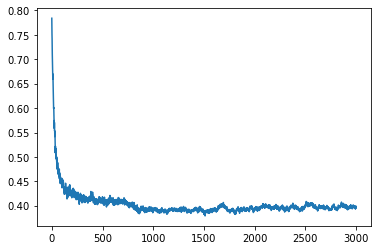

In [65]:
plt.plot(training_loss)

In [66]:
logrdata_test = LogReg(20000,2,5,1)
batch_size = 100
test_loader = DataLoader(logrdata_test, batch_size = batch_size)

def test_logistic(distributed_models, test_loader, fisher_est = False):
    if not fisher_est:
        with torch.no_grad():
            loss = []
            total = 0
            correct = 0
            for batch in test_loader:
                total += len(batch[0])
                y_i = distributed_models(batch[0])
                loss.append(loss_criterion(y_i, batch[1]))

                y_i = 1.0*(y_i >= 0.5)
                correct += torch.eq(y_i, batch[1]).sum()

            accuracy = correct / total
            avg_loss = sum(loss) / len(loss)

        return(accuracy, avg_loss)

    else:
        loss = []
        total = 0
        correct = 0
        distributed_models
        F = torch.eye(2)
        for i,batch in enumerate(test_loader):
            
            distributed_models.zero_grad()
            total += len(batch[0])
            y_i = distributed_models(batch[0])
            loss.append(loss_criterion(y_i, batch[1]))


            # estimating the fisher information requires one to calculate
            # the maximum liklihood using the labels FROM the model
            loss_f = loss_criterion(y_i, y_i)
            loss_f.backward()
            
            F_i = fisher(distributed_models)
            F = i/(i+1)*F + F_i/(i+1)
            y_i = 1.0*(y_i >= 0.5)
            correct += torch.eq(y_i, batch[1]).sum()
            
        accuracy = correct / total
        avg_loss = sum(loss) / len(loss)
        return accuracy, avg_loss, F

acc, avg_loss, F2 = test_logistic(distributed_models, test_loader, True)
print(acc, avg_loss)

tensor(0.9942) tensor(0.3980, grad_fn=<DivBackward0>)


In [67]:
print(F2)

tensor([[2.9935, 2.3864],
        [2.3864, 2.5269]])


# Easy dataset

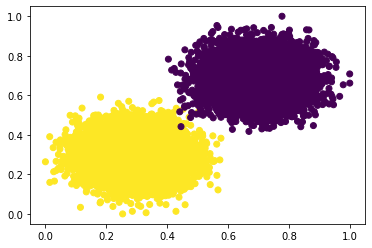

In [68]:
plt.scatter(logrdata.data[:,0].numpy(), logrdata.data[:,1].numpy(), c = logrdata.targets.numpy())

# Extract all saved weights and process them
Weights are saved both all in a list, as an overall mean, and averaged across all models at a given time

In [69]:
# Calculate the fisher information and means of weights to see sampling distr. with laplace approx

def extract_mean_weights(distributed_models):
    model = distributed_models.clients[0].model
    states = {name: 0 for name, parameter in model.named_parameters()}
    all_saved = {name: [] for name, param in model.named_parameters()}
    count = 0
    for client in distributed_models.clients:
        for saved in client.saved_weights:
            for key in saved.keys():
                count +=1
                states[key]+= saved[key]
                all_saved[key].append(saved[key])

    states = {key: states[key]/count for key in states.keys()}
    return states, all_saved

In [70]:
avg_weights = []
for i in range(len(distributed_models.clients[0].saved_weights)):
    mean_weight = 0
    for client in distributed_models.clients:
        mean_weight += client.saved_weights[i]['0.weight']
    mean_weight /= len(distributed_models.clients)
    avg_weights.append(mean_weight)

In [71]:
states, all_saved = extract_mean_weights(distributed_models)

weight_samples = torch.vstack(all_saved['0.weight']).numpy()
weight_samples_2 = torch.vstack(avg_weights).numpy()

center = states['0.weight'].numpy()[0]
center = np.mean(weight_samples, axis = 0)

In [72]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def conf_ellipse(F, center, ax, n_std = 1.0, facecolor = 'none',other=[], **kwargs):
    if len(other) == 0:
        cov = np.linalg.inv(F)
    else:
        cov = np.cov(other[:,0], other[:,1])
        
    pearson = cov[0,1]/np.sqrt(cov[0,0]*cov[1,1])
    ell_y = np.sqrt(1 - pearson)
    ell_x = np.sqrt(1 + pearson)

    ellipse = Ellipse((0, 0), width = ell_x * 2, height = ell_y * 2, facecolor = facecolor, **kwargs)
    
    scale_x = np.sqrt(cov[0,0])*n_std
    scale_y = np.sqrt(cov[1,1])*n_std
    print('info: ', scale_x, scale_y, ell_x, ell_y)

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(center[0], center[1])
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


# Confidence ellipse shows that weights are distributed correctly.

Using the laplace approximation to the posterior, which uses the inverse fisher information as the estimate of the covariance of the model weights, we can see that the model is extracting weights appro

info:  0.20636280333564544 0.20093345065152748 1.0630968156624738 0.9326441768050171
info:  0.19614918529987335 0.19820373505353928 0.9000458046727796 1.090833419680076


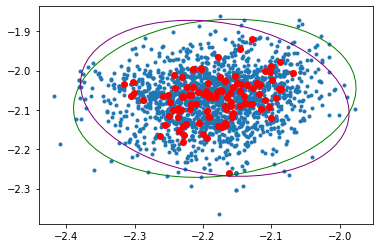

In [94]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(weight_samples[:,0], weight_samples[:,1], marker = '.')
ax.scatter(weight_samples_2[:,0], weight_samples_2[:,1], color = 'red')
center = np.mean(weight_samples, axis = 0)
ax.scatter(center[0], center[1], c = 'red', marker = 'x')
conf_ellipse(F.numpy(), center, ax, n_std = 3.0, edgecolor = 'green', other = weight_samples)

# use the training set F since it is qualitatively similar to the test set
# and matches the training data sampled weights more closely.  200 is size of samples over size of batches
conf_ellipse(F.numpy()*200, center, ax, n_std = 3.0, edgecolor = 'purple')

(array([ 11.,  31.,  98., 247., 433., 467., 421., 240.,  61.,  11.]),
 array([-2.4180558, -2.3740838, -2.330112 , -2.28614  , -2.2421682,
        -2.1981962, -2.1542242, -2.1102524, -2.0662804, -2.0223086,
        -1.9783366], dtype=float32),
 <BarContainer object of 10 artists>)

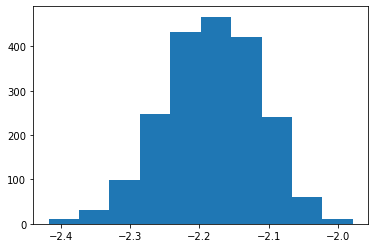

In [74]:
plt.hist(weight_samples[:,0])

(array([  1.,   7.,  42., 116., 365., 543., 586., 262.,  85.,  13.]),
 array([-2.3642652, -2.3140304, -2.2637956, -2.2135608, -2.163326 ,
        -2.1130912, -2.0628564, -2.0126216, -1.962387 , -1.9121522,
        -1.8619174], dtype=float32),
 <BarContainer object of 10 artists>)

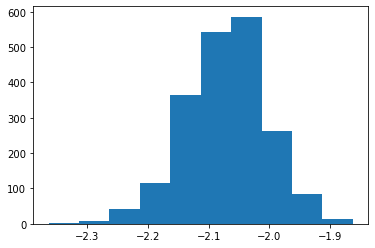

In [75]:
plt.hist(weight_samples[:,1])

# Making a cenralized model

this is for comparison

In [76]:
train_loader = DataLoader(logrdata, shuffle = True, batch_size = 100)

In [77]:
class SLR(nn.Module):
    def __init__(self):
        super(SLR, self).__init__()
        self.lin = nn.Linear(2,1)
        self.transform = nn.Sigmoid()
        self.weights = []

    def forward(self, x):
        out = self.lin(x)
        
        return self.transform(out)
    
    def sample(self):
        with torch.no_grad():
            self.weights.append({name: param.data.clone() for name, param in self.lin.named_parameters()})
    
    def fisher(self):
        g = 0
        count = 0
        F = torch.zeros(2,2)
        with torch.no_grad():
            for name, param in self.lin.named_parameters():
                if 'weight' in name:
                    if param.grad is not None:
                        g = param.grad.view(-1,1)
                        F = g @ g.T 
        return F

In [86]:
lr = .9
model = SLR()
N = 20000
optimizer = SLGD(model.parameters(), lr = lr, N = N, prior = Gaussian(0,.1), preconditioner = Euclidean)
loss_criterion = nn.BCELoss()

In [87]:
train_loss_slr = []
mu = 0.5
F_SLR = torch.eye(2)
i = 0
for epoch in range(50):
    for batch in train_loader:
        i+= 1
        optimizer.zero_grad()
        y = model(batch[0])

        loss = loss_criterion(y, batch[1])
        train_loss_slr.append(loss.detach().item())

        loss.backward()

        optimizer.step()
        
        if i >= 1000 and i % 20 == 0:
            model.sample()
            #F_SLR = (1 - mu)*F_SLR + mu*model.fisher()
            F_SLR = i/(i+1)*F_SLR + 1/(i+1)*model.fisher()
            
        if i % 100 == 0:
            print(i, loss.item())

100 0.27601882815361023
200 0.22602543234825134
300 0.20192447304725647
400 0.1839146465063095
500 0.19349943101406097
600 0.21052542328834534
700 0.18339776992797852
800 0.1939827799797058
900 0.1821022778749466
1000 0.19013240933418274
1100 0.18177473545074463
1200 0.19624961912631989
1300 0.19859124720096588
1400 0.18923017382621765
1500 0.19592782855033875
1600 0.1948612630367279
1700 0.1963692456483841
1800 0.19641506671905518
1900 0.1833461970090866
2000 0.19357775151729584
2100 0.19329120218753815
2200 0.18473629653453827
2300 0.20244693756103516
2400 0.1877889782190323
2500 0.19312551617622375
2600 0.18196111917495728
2700 0.18634283542633057
2800 0.1988385170698166
2900 0.18870557844638824
3000 0.18010717630386353
3100 0.18592201173305511
3200 0.1930994987487793
3300 0.19117875397205353
3400 0.1892959177494049
3500 0.18840837478637695
3600 0.1877625286579132
3700 0.19691406190395355
3800 0.18241822719573975
3900 0.20223486423492432
4000 0.20163054764270782
4100 0.1880939453840

In [88]:
F_SLR

tensor([[8.9079e-01, 9.9502e-06],
        [9.9502e-06, 8.9079e-01]])

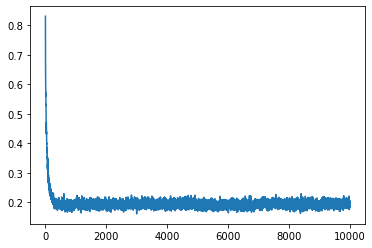

In [89]:
plt.plot(train_loss_slr)

In [90]:
saved_weights_slr = []
for weights in model.weights:
    saved_weights_slr.append(weights['weight'].data)

In [91]:
saved_weights_slr = torch.vstack(saved_weights_slr).numpy()

In [92]:
acc, loss = test_logistic(model, test_loader)

print(acc, loss)

tensor(0.9998) tensor(0.2011)


info:  0.22399948321325935 0.20676638464607933 0.731563246000795 1.2102955081717772
info:  0.2247599959373474 0.22475995123386383 0.9999944149379658 1.0000055850308416


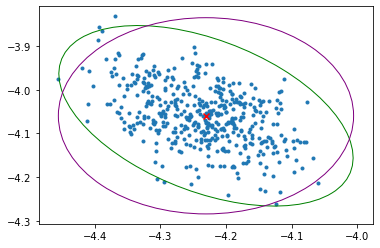

In [93]:

fig = plt.figure()
ax = plt.gca()
ax.scatter(saved_weights_slr[:,0], saved_weights_slr[:,1], marker = '.')
center = np.median(saved_weights_slr, axis = 0)
ax.scatter(center[0], center[1], c = 'red', marker = 'x')
conf_ellipse(F.numpy(), center, ax, n_std = 3.0, edgecolor = 'green', other = saved_weights_slr)

# 200 is size of samples over size of batches
conf_ellipse(F_SLR*200, center, ax, n_std = 3.0, edgecolor = 'purple')